In [319]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, irfft
import numpy.random as rand

plt.rcParams['font.size'] = 15

In [320]:
TSAMP = 2.56*512*0.75*1e-6
f = 2.1742896426624596 #Hz
flux = 1 #mJy
Npol = 2
delta_f = 200e6 #need more precise way of grabbing this but right now this is not stored.
tau = 10*60 #in seconds; depends on ra/dec. should be stored in pspec but currently isnt.
GAIN= 1.16e-3 #K mJy^-1
TSYS = 30 #K
BETA = 1.1

Demo of our implementation of Parseval's theorem:
$$\text{Var}(x_k) = \frac{1}{N} \langle|a_j|^2\rangle$$

Text(0.5, 1.0, 'Output Noise Mean for Time Domain RMS = $\\frac{1}{\\sqrt{N}}$')

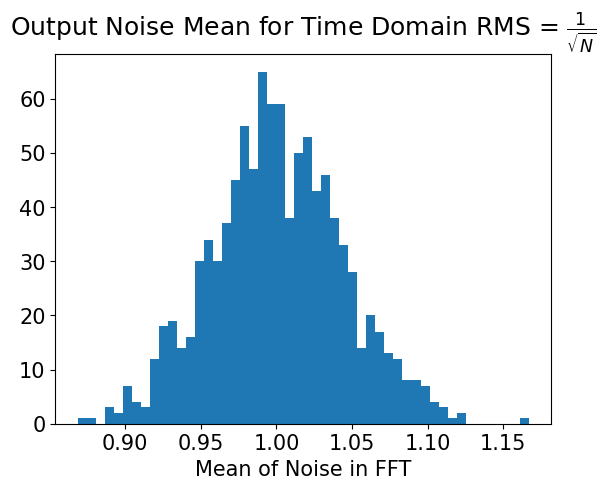

In [321]:
N = 1024
RMS = np.sqrt(1 / N)
noise = rand.normal(0, RMS, (1000, N))
noise_pows = np.zeros((1000, int(N/2)))
for i in range(1000):
    noise_fft = rfft(noise[i])[1:]
    noise_pows[i] = np.abs(noise_fft)**2
    
noise_means = np.mean(noise_pows, axis = 1)
hist = plt.hist(noise_means, bins = 50)
plt.xlabel('Mean of Noise in FFT')
plt.title(r'Output Noise Mean for Time Domain RMS = $\frac{1}{\sqrt{N}}$')

In [322]:
def gaussian(mu, sig, N):
    x = np.linspace(0, 1, N)
    return np.exp(-0.5 * ((x - mu) / sig) ** 2) / (sig * np.sqrt(2 * np.pi))

Demo of flux retrieval as we decrease harmonics:
$$A = S \times \text{RMS} \times \sqrt{N_{pol} \Delta \nu \frac{\tau}{N}} \times * \frac{G}{T_{sys} \beta}$$

Retrieved flux = 0.996800484854777 mJy


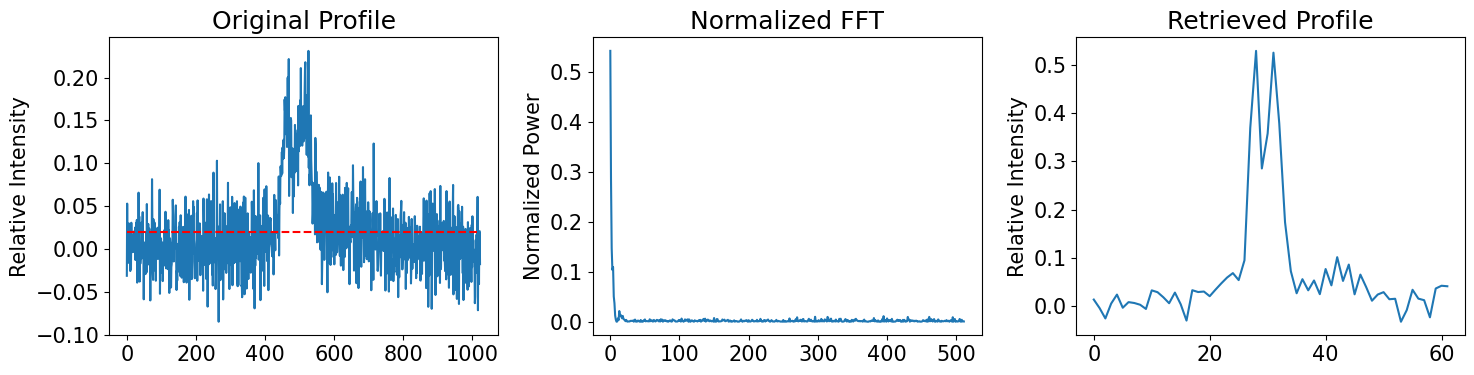

In [323]:
flux = 1 #mJy
Nbin = 1024
RMS = np.sqrt(1 / Nbin)
signal = flux * RMS * np.sqrt(Npol * delta_f * tau / Nbin) * GAIN / TSYS / BETA 
prof = gaussian(0.5, 0.02, Nbin) + gaussian(0.54, 0.1, Nbin) + 0.5*gaussian(0.45, 0.01, Nbin)
prof *= signal / np.mean(prof)
prof += rand.normal(0, RMS, Nbin)

prof_fft = rfft(prof) / (Nbin / 2)**(1/2)
phases = np.angle(prof_fft)[1:]
pows = np.abs(prof_fft[1:])**2
norm_pows = pows 
nharm = 32
retrieved_fft = np.sqrt(norm_pows[:nharm]) * np.exp(1j * (phases[:nharm] - np.pi)) 
retrieved_prof = irfft(retrieved_fft) * np.sqrt(nharm)
RMS = np.sqrt(1 / 2 / nharm)
A = np.mean(retrieved_prof)
retrieved_flux = A * TSYS * BETA / GAIN / np.sqrt(Npol * delta_f * tau / Nbin) / RMS
print(f'Retrieved flux = {retrieved_flux} mJy')

fig, ax = plt.subplots(1, 3, figsize = (15, 4))
ax[0].set_title('Original Profile')
ax[0].plot(prof)
ax[0].hlines(np.mean(prof), xmin = 0, xmax = Nbin, linestyle = '--', color = 'red', label = 'Mean')
ax[0].set_ylabel('Relative Intensity')
ax[1].plot(norm_pows)
ax[1].set_title('Normalized FFT')
ax[1].set_ylabel('Normalized Power')
ax[2].set_title('Retrieved Profile')
ax[2].plot(retrieved_prof)
ax[2].set_ylabel('Relative Intensity')
plt.tight_layout()

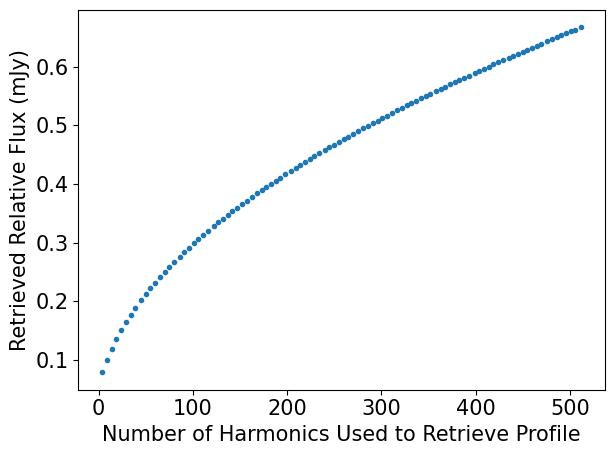

In [324]:
flux = 1 #mJy
Nbin = 1024
RMS = np.sqrt(1 / Nbin)
signal = flux * RMS * np.sqrt(Npol * delta_f * tau / Nbin) * GAIN / TSYS / BETA 
prof = gaussian(0.5, 0.02, Nbin) + gaussian(0.54, 0.1, Nbin) + 0.5*gaussian(0.45, 0.01, Nbin)
prof *= signal / np.mean(prof)
prof += rand.normal(0, RMS, Nbin)

prof_fft = rfft(prof) / (Nbin / 2)**(1/2)
phases = np.angle(prof_fft)[1:]
pows = np.abs(prof_fft[1:])**2
norm_pows = pows 

n_nharm = 100
output_fluxes = np.zeros(n_nharm)
input_nharm = np.linspace(4, 512, n_nharm, dtype = 'int')
for i in range(n_nharm):

    prof = gaussian(0.5, 0.02, Nbin) + gaussian(0.54, 0.1, Nbin) + 0.5*gaussian(0.45, 0.01, Nbin)
    prof *= signal / np.mean(prof)
    prof += rand.normal(0, RMS, Nbin)

    nharm = input_nharm[i]
    retrieved_fft = np.sqrt(norm_pows[:nharm]) * np.exp(1j * (phases[:nharm] - np.pi)) 
    retrieved_prof = irfft(retrieved_fft) * np.sqrt(nharm)
    RMS = np.sqrt(1 / 2 / nharm)
    A = np.mean(retrieved_prof)
    retrieved_flux = A * TSYS * BETA / GAIN / np.sqrt(Npol * delta_f * tau / nharm) / RMS
    output_fluxes[i] = retrieved_flux

plt.plot(input_nharm, output_fluxes, '.')
plt.xlabel('Number of Harmonics Used to Retrieve Profile')
plt.ylabel('Retrieved Relative Flux (mJy)')
plt.tight_layout()